___

<a href='http://www.pieriandata.com'> <img src='../c88f710347aed645fd9b42f4e937b5df.jpg' style="width: 300px;"/></a>
___

For this project, we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set on Kaggle! 

We'll be trying to predict a classification- survival or deceased by implementing Logistic Regression in Python for classification.


## Import Libraries
Let's import some libraries to get started!

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cufflinks as cf
from ipywidgets import interactive
cf.go_offline()

In [76]:
def plot_func(a, f):
    plt.figure(2)
    x = np.linspace(0, 2*np.pi, num=1000)
    y = a*np.sin(1/f*x)
    plt.plot(x,y)
    plt.ylim(-1.1, 1.1)
    plt.title('a sin(f)')
    plt.show()

interactive_plot = interactive(plot_func, a=(-1,0,0.1), f=(0.1, 1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(FloatSlider(value=-1.0, description='a', max=0.0, min=-1.0), FloatSlider(value=0.55, des…

In [77]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Pranav' is not recognized as an internal or external command,
operable program or batch file.


## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [78]:
train = pd.read_csv('titanic_train.csv')

In [79]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Below are the interpretations of each of the columns in the data

|Variable	  |Definition	                              |Key                                           |
|-------------|-------------------------------------------|----------------------------------------------|
|survival	  |Survival	                                  |0 = No, 1 = Yes                               |
|pclass	      |Ticket class	                              |1 = 1st, 2 = 2nd, 3 = 3rd                     |
|sex	      |Sex	                                      |                                              |
|Age	      |Age in years	                              |                                              |
|sibsp	      |# of siblings / spouses aboard the Titanic |                                              |
|parch	      |# of parents / children aboard the Titanic |                                              |
|ticket	      |Ticket number	                          |                                              |
|fare	      |Passenger fare	                          |                                              |
|cabin	      |Cabin number	                              |                                              |
|embarked	  |Port of Embarkation	                      |C = Cherbourg, Q = Queenstown, S = Southampton|

# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

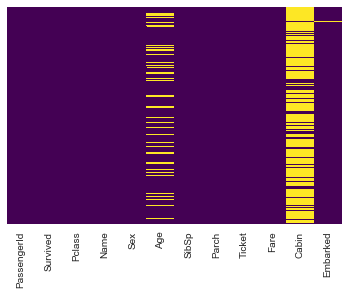

In [80]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let us find the percent of instances where the age is missing

In [81]:
train.isnull()['Age'].value_counts()

False    714
True     177
Name: Age, dtype: int64

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

#### Let's continue on by visualizing some more of the data!

First, let's compare how many people survived and how many did not, overall

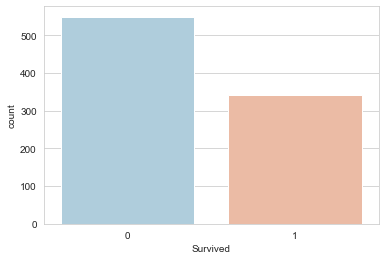

In [82]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

### So, roughly 40% of the passengers survived!

Next, let's check if the above had any gender causalities

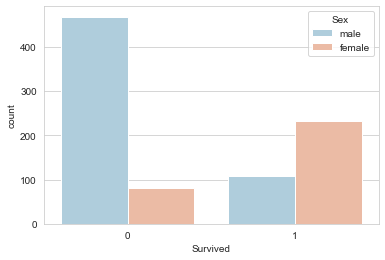

In [83]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

### Interesting! Out of the passengers who died, just 20% were female; but out of the passengers who survived 70% were female! Did this mean that many men died saving women much like Jack did?!

Next, let's check if the survival rate had any relation to the class of ticket the passenger held

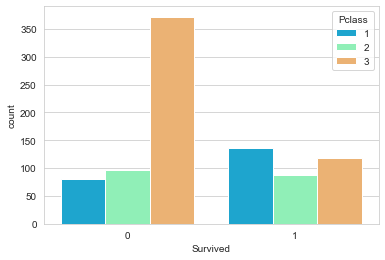

In [84]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

### The people who survived are almost equal across classes. This strongly suggests that all classes of passengers were given equal prority in rescue.

### The passengers who travelled in 3rd class and died, were 200% more than those travelling in 1st and 2nd classes! But this could be due to the higher no. of people travelling in 3rd. 

Next, let's check if the survvial rate had any relation with age

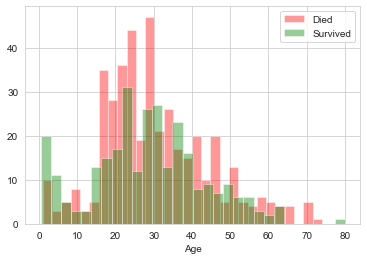

In [85]:
sns.distplot(train[train['Survived']==0]['Age'].dropna(),kde=False,color='red',bins=30,)
sns.distplot(train[train['Survived']==1]['Age'].dropna(),kde=False,color='green',bins=30,)
plt.legend(['Died','Survived'])

### The histograms of ages of people who died and survived follow almost the same trend. We can thus conclude that age did not play a role in survival.

### Though it should be noted that a lot of babies aged 0-1 survived, mostly because adult survivors would always carry any babies with them.

Next, let's check if the survival rate had any relation with no. of siblings/spouses the people had on board

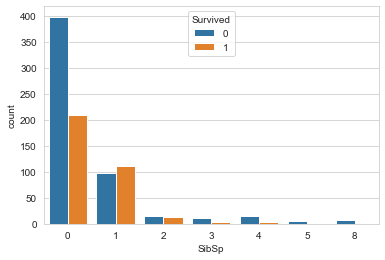

In [86]:
sns.countplot(x='SibSp',data=train,hue='Survived')

### People who had no spouses/siblings were a lot more likely to die. Similarly having 1-2 spouse/siblings helped survival!

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


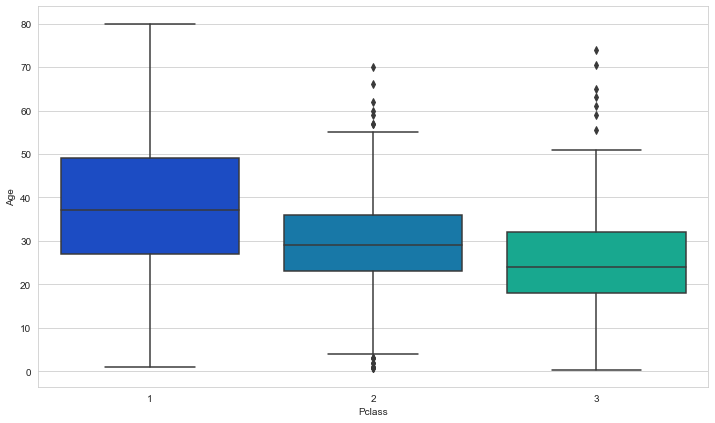

In [87]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [88]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now we apply that function to replace all the missing values of age!

In [89]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

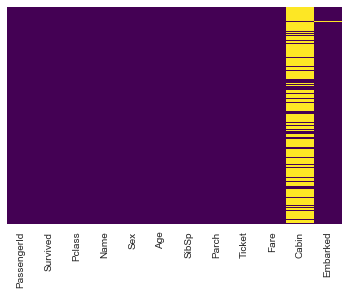

In [90]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [91]:
train.drop('Cabin',axis=1,inplace=True)

In [92]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [93]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [96]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [97]:
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

In [98]:
train = pd.concat([train,sex,embark],axis=1)

In [99]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101) 

## Training and Predicting

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
X_train

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
807,3,18.0,0,0,7.7750,0,0,1
651,2,18.0,0,1,23.0000,0,0,1
2,3,26.0,0,0,7.9250,0,0,1
690,1,31.0,1,0,57.0000,1,0,1
196,3,24.0,0,0,7.7500,1,1,0
...,...,...,...,...,...,...,...,...
576,2,34.0,0,0,13.0000,0,0,1
840,3,20.0,0,0,7.9250,1,0,1
338,3,45.0,0,0,8.0500,1,0,1
524,3,24.0,0,0,7.2292,1,0,0


In [104]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
predictions = logmodel.predict(X_test)

In [106]:
import pickle
pickle.dump(logmodel, open('model.pkl', 'wb'))

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [107]:
from sklearn.metrics import classification_report

In [108]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       163
           1       0.85      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



In [109]:
from sklearn.metrics import confusion_matrix

In [110]:
confm = confusion_matrix(y_test, predictions)
confm

array([[150,  13],
       [ 32,  72]], dtype=int64)

Let's plot this confusion matrix using seaborn to make it a little intuitive

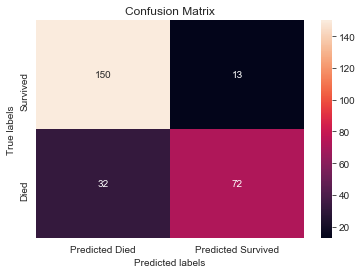

In [112]:
ax= plt.subplot()
sns.heatmap(confm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Predicted Died','Predicted Survived']); ax.yaxis.set_ticklabels(['Survived','Died']);

Let's find out the accuracy & errors in prediction to find out if this is a good model

In [113]:
print ('Accuracy of the model is %.2f percent' %((confm[0][0]+confm[1][1])/confm.sum()*100))

Accuracy of the model is 83.15 percent


In [114]:
print ('Misclassification rate of the model is %.2f percent' %((confm[0][1]+confm[1][0])/confm.sum()*100))

Misclassification rate of the model is 16.85 percent


### This basic model of ours seems to be working quite well! We accept it as is for now